<a href="https://colab.research.google.com/github/seongheechoi/education/blob/main/%EC%8B%A4%EC%8A%B5_1_4_compile_TFLite_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TVM 실습자료 1: Compile TFLite Models**

In [ ]:
!pip install numpy==1.26.4
import numpy as np
print(np.__version__)
!pip list | grep numpy

1.26.4
numpy                                 1.26.4


In [ ]:
!python -m pip install --upgrade pip
!pip install apache-tvm

In [ ]:
!pip install tflite==2.1.0
!pip install -U matplotlib

In [ ]:
import os


def extract(path):
    import tarfile

    if path.endswith("tgz") or path.endswith("gz"):
        dir_path = os.path.dirname(path)
        tar = tarfile.open(path)
        tar.extractall(path=dir_path)
        tar.close()
    else:
        raise RuntimeError("Could not decompress the file: " + path)

In [ ]:
from tvm.contrib.download import download_testdata

model_url = "http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/mobilenet_v1_1.0_224.tgz"

# Download model tar file and extract it to get mobilenet_v1_1.0_224.tflite
model_path = download_testdata(model_url, "mobilenet_v1_1.0_224.tgz", module=["tf", "official"])
model_dir = os.path.dirname(model_path)
extract(model_path)

# Now we can open mobilenet_v1_1.0_224.tflite
tflite_model_file = os.path.join(model_dir, "mobilenet_v1_1.0_224.tflite")
tflite_model_buf = open(tflite_model_file, "rb").read()

# Get TFLite model from buffer
try:
    import tflite

    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
except AttributeError:
    import tflite.Model

    tflite_model = tflite.Model.Model.GetRootAsModel(tflite_model_buf, 0)

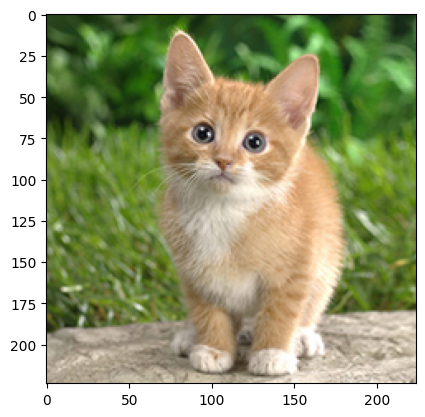

input (1, 224, 224, 3)


In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

image_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
image_path = download_testdata(image_url, "cat.png", module="data")
resized_image = Image.open(image_path).resize((224, 224))
plt.imshow(resized_image)
plt.show()
image_data = np.asarray(resized_image).astype("float32")

# Add a dimension to the image so that we have NHWC format layout
image_data = np.expand_dims(image_data, axis=0)

# Preprocess image as described here:
# https://github.com/tensorflow/models/blob/edb6ed22a801665946c63d650ab9a0b23d98e1b1/research/slim/preprocessing/inception_preprocessing.py#L243
image_data[:, :, :, 0] = 2.0 / 255.0 * image_data[:, :, :, 0] - 1
image_data[:, :, :, 1] = 2.0 / 255.0 * image_data[:, :, :, 1] - 1
image_data[:, :, :, 2] = 2.0 / 255.0 * image_data[:, :, :, 2] - 1
print("input", image_data.shape)

In [ ]:
import tvm

# TFLite input tensor name, shape and type
input_tensor = "input"
input_shape = (1, 224, 224, 3)
input_dtype = "float32"

# Parse TFLite model and convert it to a Relay module
from tvm import relay, transform

mod, params = relay.frontend.from_tflite(
    tflite_model, shape_dict={input_tensor: input_shape}, dtype_dict={input_tensor: input_dtype}
)

# We assume our model's heavily-layout sensitive operators only consist of nn.conv2d
desired_layouts = {'nn.conv2d': ['NCHW', 'default']}

# Convert the layout to NCHW
# RemoveUnunsedFunctions is used to clean up the graph.
seq = transform.Sequential([relay.transform.RemoveUnusedFunctions(),
                                relay.transform.ConvertLayout(desired_layouts)])
with transform.PassContext(opt_level=3):
    mod = seq(mod)

# Build the module against to x86 CPU
target = "llvm"
with transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

In [ ]:
import tvm
from tvm import te
from tvm.contrib import graph_executor as runtime

# Create a runtime executor module
module = runtime.GraphModule(lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()

# Get output
tvm_output = module.get_output(0).numpy()

In [ ]:
# Load label file
label_file_url = "".join(
    [
        "https://raw.githubusercontent.com/",
        "tensorflow/tensorflow/master/tensorflow/lite/java/demo/",
        "app/src/main/assets/",
        "labels_mobilenet_quant_v1_224.txt",
    ]
)
label_file = "labels_mobilenet_quant_v1_224.txt"
label_path = download_testdata(label_file_url, label_file, module="data")

# List of 1001 classes
with open(label_path) as f:
    labels = f.readlines()

# Convert result to 1D data
predictions = np.squeeze(tvm_output)

# Get top 1 prediction
prediction = np.argmax(predictions)

# Convert id to class name and show the result
print("The image prediction result is: id " + str(prediction) + " name: " + labels[prediction])

The image prediction result is: id 283 name: tiger cat

